## Compare Training Site Spectral Signatures between SR and TOA Data

In [1]:
# Import GEE & initialize
import os
import ee
# import geemap
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize GEE
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Import Training Data

In [2]:
# Source Assets
assets_locn = "projects/ee-abnatcap/assets/sargassum"
# SR samples
sr_samples = "samples_S2sr_20190507_allbands"
samples_sr_ee = ee.FeatureCollection(os.path.join(assets_locn, sr_samples))
print("Column names: ", samples_sr_ee.first().propertyNames().getInfo())
print('Count: ', samples_sr_ee.size().getInfo())
# TOA samples
toa_samples = "samples_S2toa_20190507_allbands"
samples_toa_ee = ee.FeatureCollection(os.path.join(assets_locn, toa_samples))
print("Column names: ", samples_toa_ee.first().propertyNames().getInfo())
print('Count: ', samples_toa_ee.size().getInfo())

Column names:  ['B11', 'B12', 'NDVI_dmed', 'SAVI', 'NDVI_min', 'NDVI_stdDev', 'B8A', 'NDVI', 'lc_code', 'FAI', 'B2', 'random', 'B3', 'B4', 'NDVI_median', 'B5', 'AFAI', 'B6', 'B7', 'B8', 'SEI', 'NDVI_mean', 'NDVI_max', 'system:index']
Count:  38799
Column names:  ['B11', 'B12', 'NDVI_dmed', 'SAVI', 'NDVI_min', 'NDVI_stdDev', 'B8A', 'NDVI', 'lc_code', 'FAI', 'B2', 'random', 'B3', 'B4', 'NDVI_median', 'B5', 'AFAI', 'B6', 'B7', 'B8', 'SEI', 'NDVI_mean', 'NDVI_max', 'system:index']
Count:  38799


In [3]:
## Export Training Samples to Google Drive  -- One Time only
google_drive_local = '/Users/arbailey/Google Drive/My Drive'
output_folder = 'geeout'

# Only needed to do this once or when the training sites change
# # SR Ouptut
# task = ee.batch.Export.table.toDrive(collection=samples_sr_ee,
#                                          description=sr_samples,
#                                          folder=output_folder,
#                                          fileFormat='GeoJSON')
# task.start()
# # TOA Ouptut
# task = ee.batch.Export.table.toDrive(collection=samples_toa_ee,
#                                          description=toa_samples,
#                                          folder=output_folder,
#                                          fileFormat='GeoJSON')
# task.start()

In [4]:
# Import Samples into GeoDataFrame
samples_sr_geojson = os.path.join(google_drive_local,output_folder,sr_samples + ".geojson")
samples_toa_geojson = os.path.join(google_drive_local,output_folder,toa_samples  + ".geojson")

samples_sr_gdf = gpd.read_file(samples_sr_geojson)
samples_toa_gdf = gpd.read_file(samples_toa_geojson)

print(samples_sr_gdf.crs)
print(samples_sr_gdf.columns)
print(samples_sr_gdf.head)
print(samples_toa_gdf.head)

epsg:4326
Index(['id', 'AFAI', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'FAI', 'NDVI', 'NDVI_dmed', 'NDVI_max', 'NDVI_mean',
       'NDVI_median', 'NDVI_min', 'NDVI_stdDev', 'SAVI', 'SEI', 'lc_code',
       'random', 'geometry'],
      dtype='object')
<bound method NDFrame.head of                          id      AFAI     B11     B12      B2      B3      B4  \
0      0000000000000000686d  0.078725  0.0393  0.0383  0.0709  0.0922  0.0861   
1      0000000000000000686e  0.084600  0.0393  0.0383  0.0628  0.0874  0.0767   
2      00000000000000006877  0.082412  0.0393  0.0383  0.0673  0.0907  0.0802   
3      00000000000000006878  0.086038  0.0393  0.0383  0.0604  0.0835  0.0744   
4      000000000000000064bd  0.041962  0.0301  0.0276  0.0565  0.0834  0.0661   
...                     ...       ...     ...     ...     ...     ...     ...   
38794  00000000000000003123 -0.009075  0.1544  0.1138  0.1744  0.1616  0.1298   
38795  00000000000000003124 -0.012200  0.

### Reshape and Plot Signatures

In [5]:
# Reshape data frame to a normalized format for bands/indices plotting

model_bands = ['B2','B5','B8','B8A','B12','FAI','SEI', 'NDVI','NDVI_median','NDVI_min','NDVI_dmed']

def normalize_gdf(samples_gdf): 
    normalized_gdf = samples_gdf.melt(id_vars=['lc_code'], value_vars=model_bands,
        var_name='band_index', value_name='value')
    conditions = [
        (normalized_gdf['lc_code'] == 0),
        (normalized_gdf['lc_code'] == 1),
        (normalized_gdf['lc_code'] == 2),
        (normalized_gdf['lc_code'] == 3),
        (normalized_gdf['lc_code'] == 4),
        ]
    lc_names = ['sargassum', 'other veg', 'beach', 'buildings', 'clouds']
    normalized_gdf['lc'] = np.select(conditions, lc_names)
    return normalized_gdf

samples_sr_norm_gdf = normalize_gdf(samples_sr_gdf)
samples_sr_norm_gdf

samples_toa_norm_gdf = normalize_gdf(samples_toa_gdf)
samples_toa_norm_gdf

,lc_code,band_index,value,lc
0,0,B2,0.131300,sargassum
1,0,B2,0.117800,sargassum
2,0,B2,0.140900,sargassum
3,0,B2,0.129300,sargassum
4,0,B2,0.107900,sargassum
...,...,...,...,...
426784,4,NDVI_dmed,0.193761,clouds
426785,4,NDVI_dmed,0.146740,clouds
426786,4,NDVI_dmed,0.225236,clouds
426787,4,NDVI_dmed,0.193388,clouds


#### Grouped Boxplot for All Land Cover -- SR & TOA

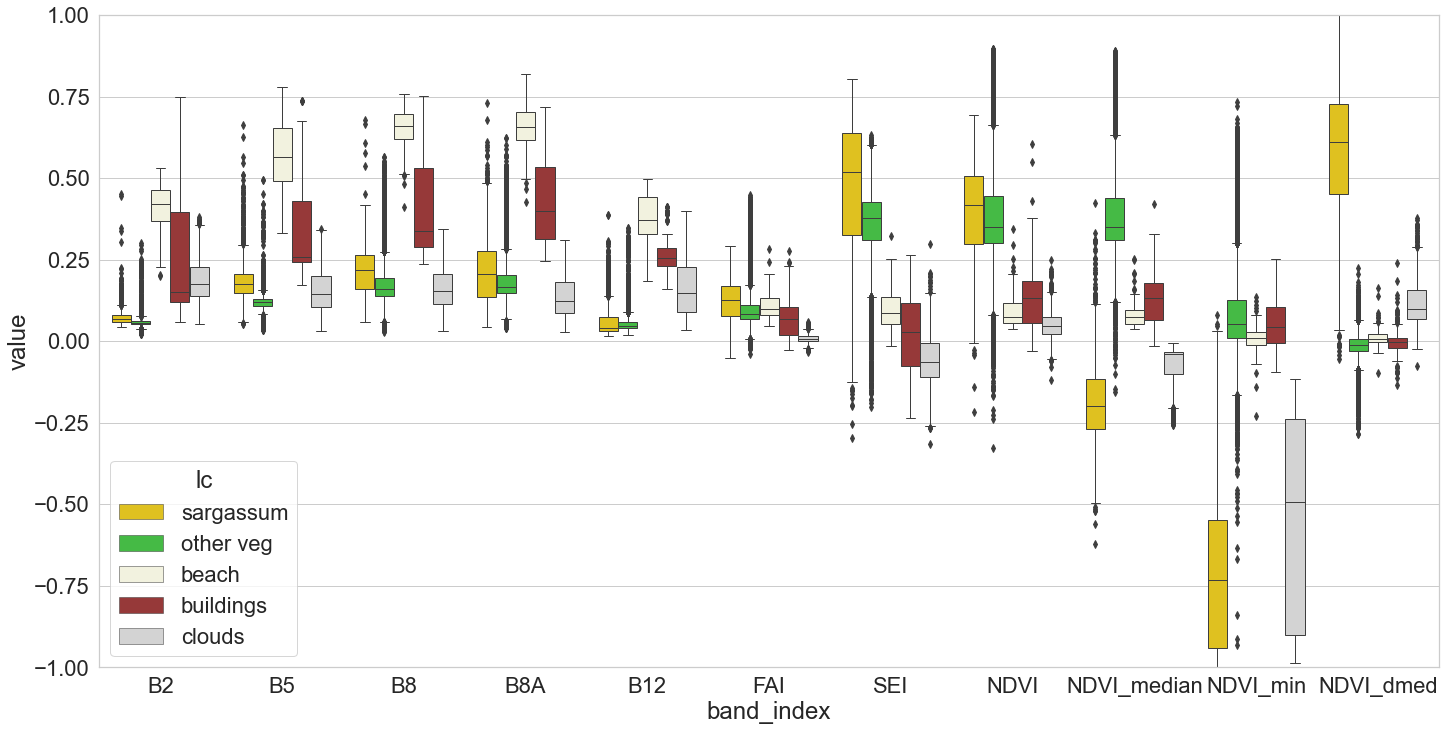

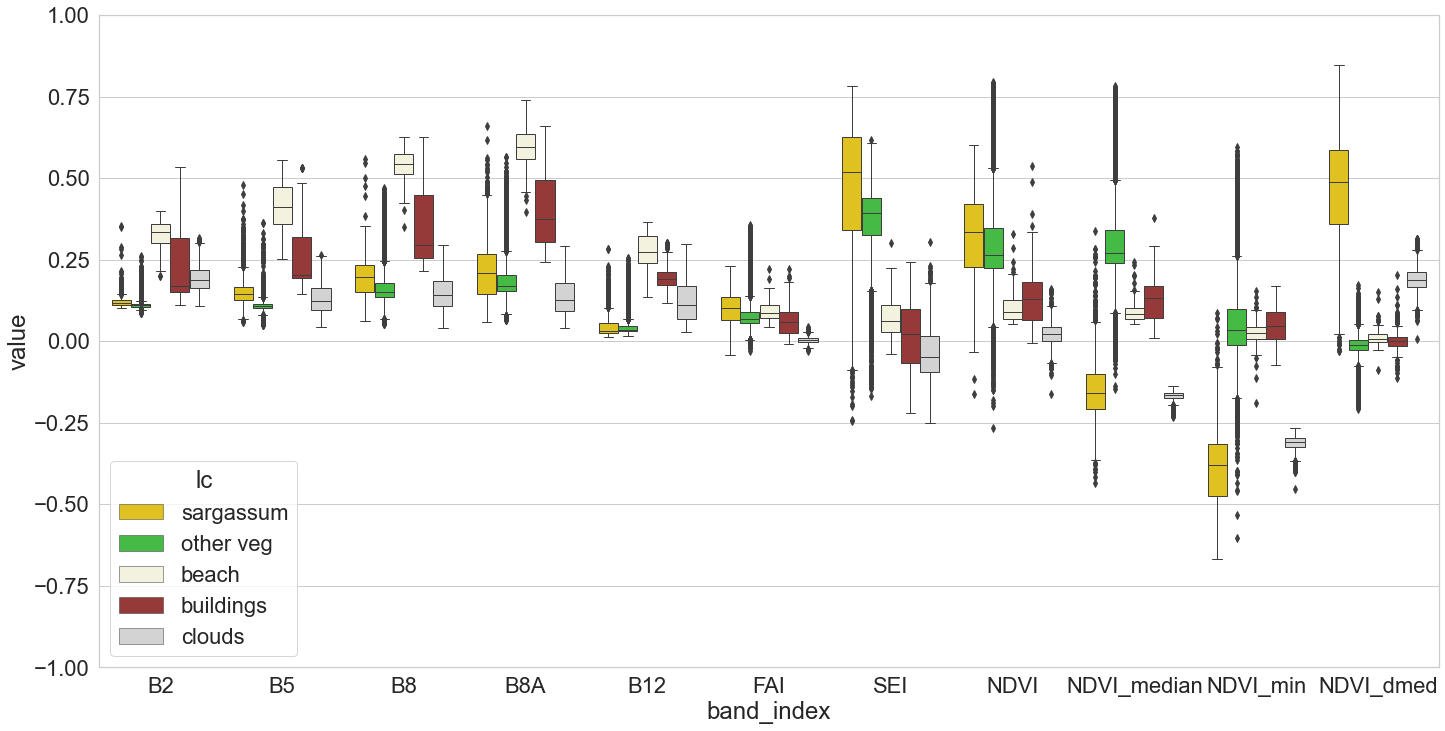

In [6]:
lc_palette = {"sargassum": "gold", "other veg": "limegreen", "beach":"beige", 'buildings':'brown', 'clouds':'lightgrey'}

def group_boxplot(samples_norm_gdf):
    """ Creates a grouped box plot for a all landcover codes"""
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
    f, ax = plt.subplots(figsize=(24, 12))
    plt.ylim(-1, 1)
    sns.boxplot(x='band_index', y='value', hue='lc', data=samples_norm_gdf, palette=lc_palette)    

group_boxplot(samples_sr_norm_gdf)
group_boxplot(samples_toa_norm_gdf)

#### Box Plots for each Land Cover Individually -- SR & TOA

In [7]:
def single_boxplot(samples_norm_gdf, lc_code):
    """ Creates a box plot for a single landcover code"""
    sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})
    f, ax = plt.subplots(figsize=(10, 10))
    plt.ylim(-1, 1)
    sns.boxplot(x='band_index', y='value', hue='lc', data=samples_norm_gdf[samples_norm_gdf["lc_code"] == lc_code], palette=lc_palette)

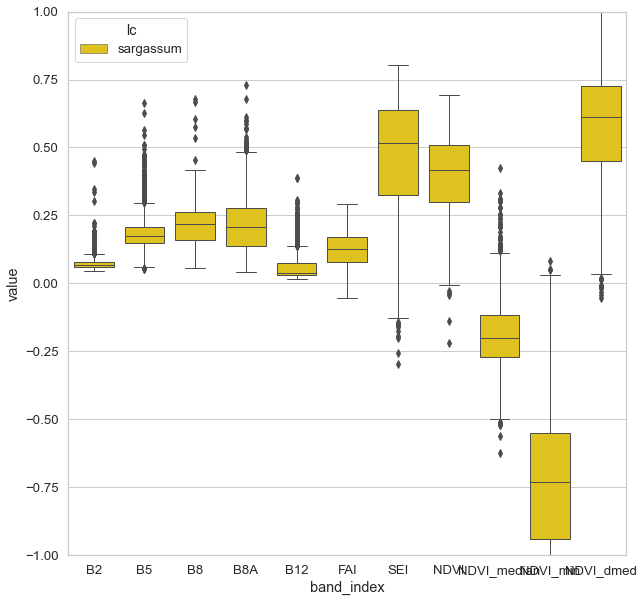

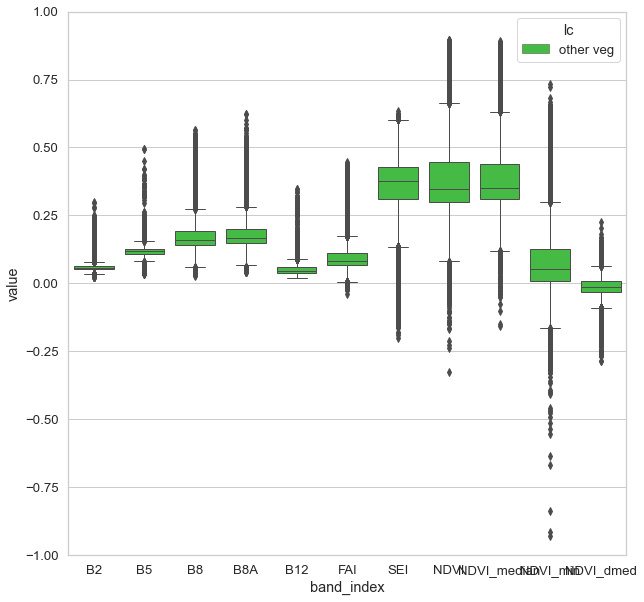

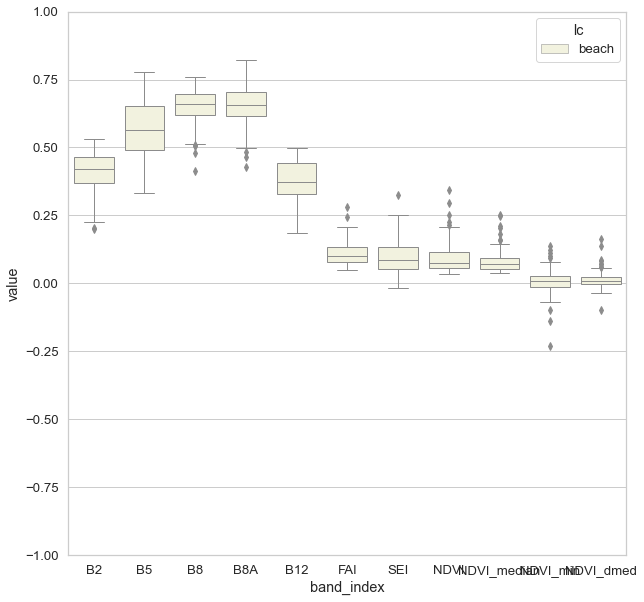

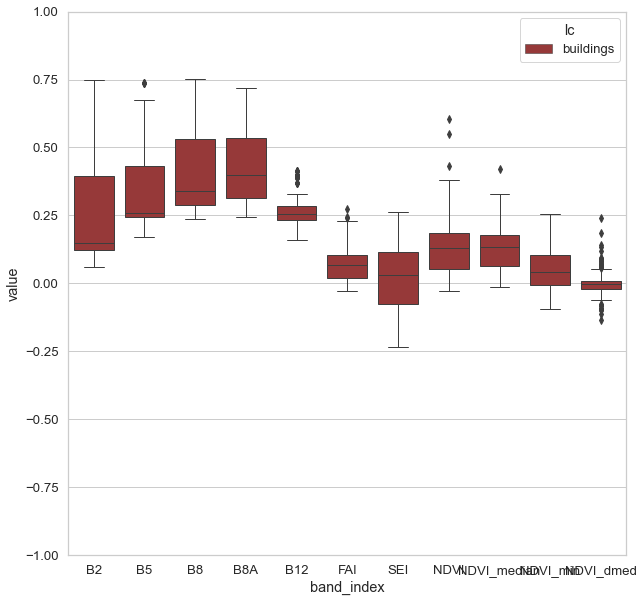

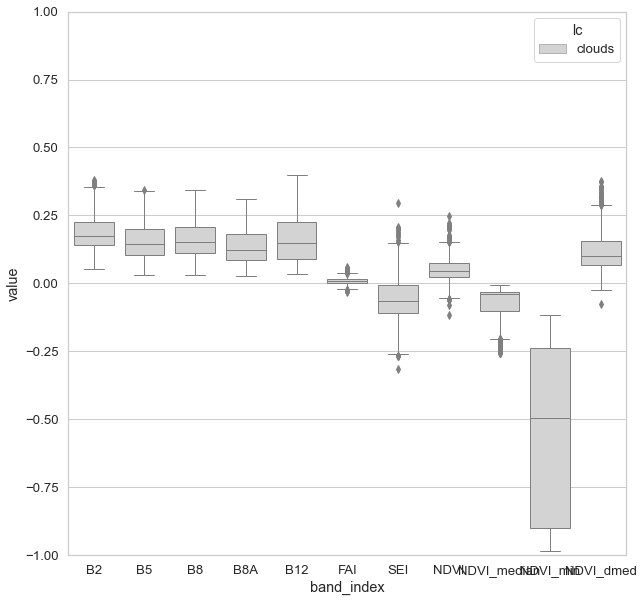

In [8]:
# Single BoxPlots - SR
single_boxplot(samples_sr_norm_gdf, 0)
single_boxplot(samples_sr_norm_gdf, 1)
single_boxplot(samples_sr_norm_gdf, 2)
single_boxplot(samples_sr_norm_gdf, 3)
single_boxplot(samples_sr_norm_gdf, 4)


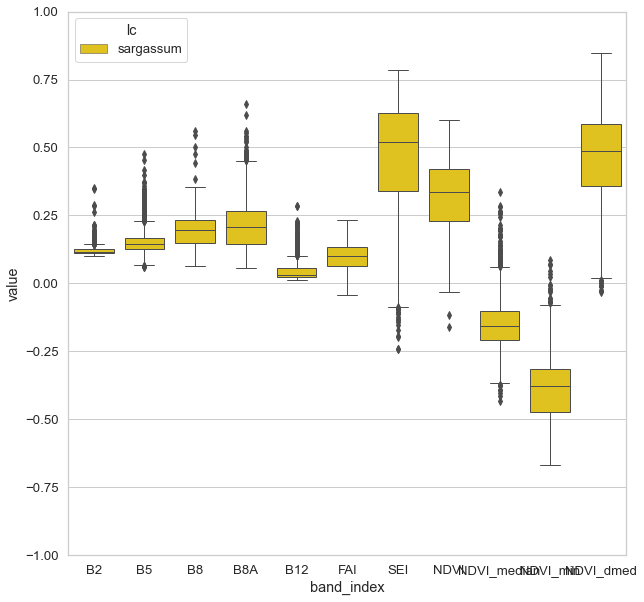

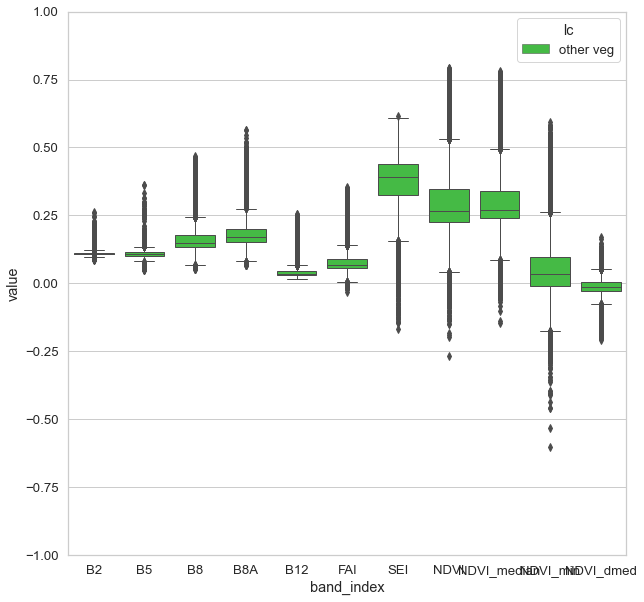

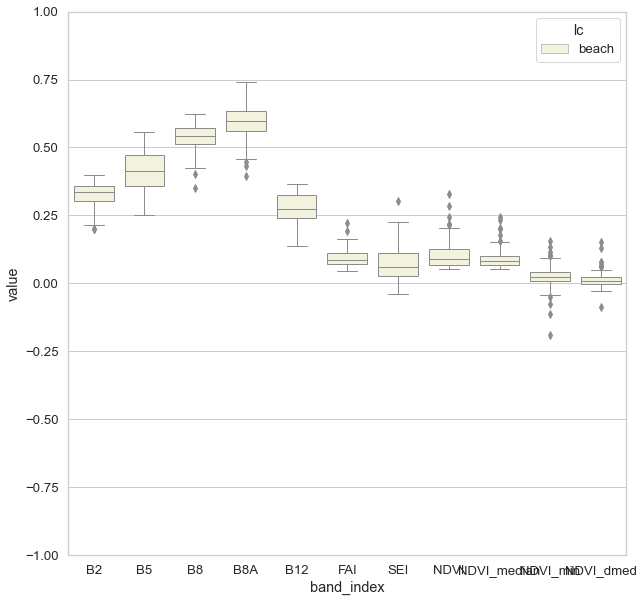

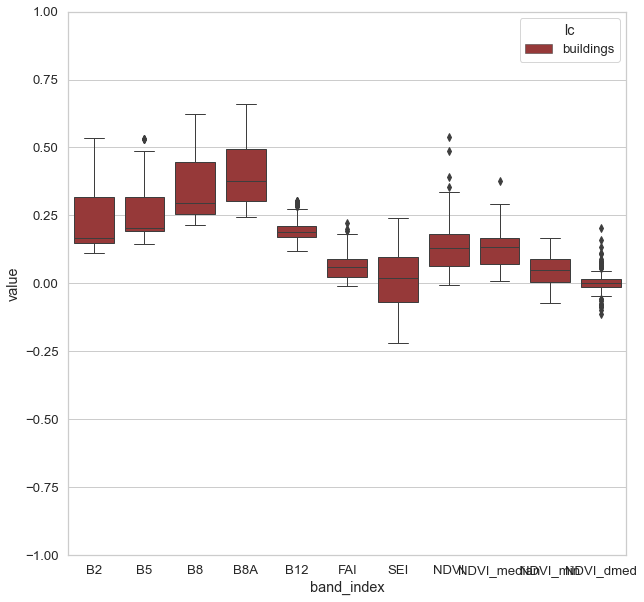

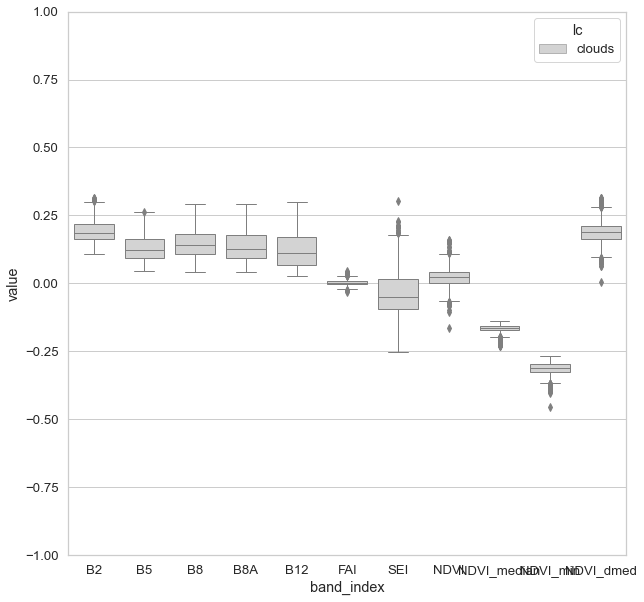

In [9]:
# Single BoxPlots - TOA
single_boxplot(samples_toa_norm_gdf, 0)
single_boxplot(samples_toa_norm_gdf, 1)
single_boxplot(samples_toa_norm_gdf, 2)
single_boxplot(samples_toa_norm_gdf, 3)
single_boxplot(samples_toa_norm_gdf, 4)

In [10]:
def multi_boxplot(samples_norm_gdf):
    """ Creates a set of box plots for all land cover codes"""
    sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})
    f, axes = plt.subplots(2, 3,figsize=(24, 12), sharey=True)
    plt.ylim(-1, 1)
    sns.boxplot(ax=axes[0, 0], x='band_index', y='value', hue='lc', data=samples_norm_gdf[samples_norm_gdf["lc_code"] == 0], palette=lc_palette)
    sns.boxplot(ax=axes[0, 1], x='band_index', y='value', hue='lc', data=samples_norm_gdf[samples_norm_gdf["lc_code"] == 1], palette=lc_palette)
    sns.boxplot(ax=axes[0, 2], x='band_index', y='value', hue='lc', data=samples_norm_gdf[samples_norm_gdf["lc_code"] == 4], palette=lc_palette)
    sns.boxplot(ax=axes[1, 0], x='band_index', y='value', hue='lc', data=samples_norm_gdf[samples_norm_gdf["lc_code"] == 3], palette=lc_palette)
    sns.boxplot(ax=axes[1, 1], x='band_index', y='value', hue='lc', data=samples_norm_gdf[samples_norm_gdf["lc_code"] == 2], palette=lc_palette)
    f.delaxes(ax=axes[1,2])

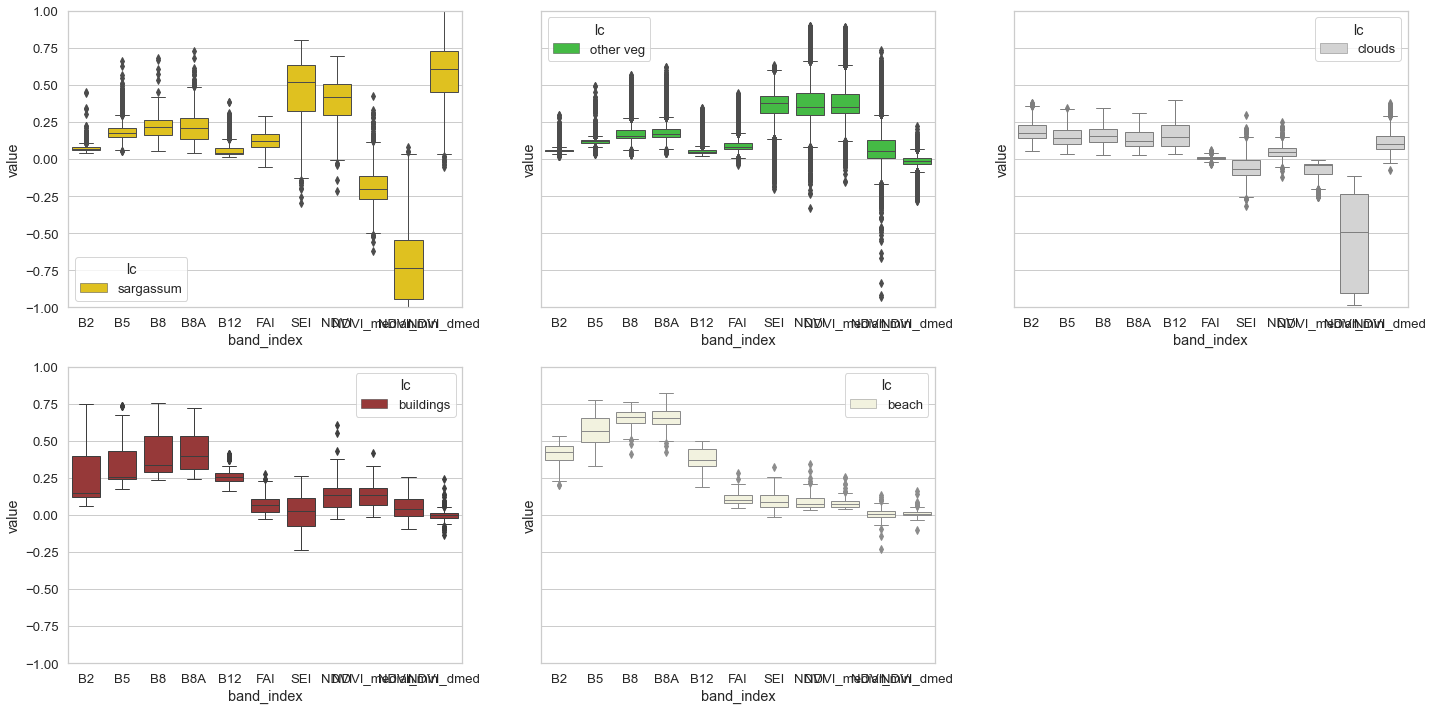

In [11]:
multi_boxplot(samples_sr_norm_gdf)


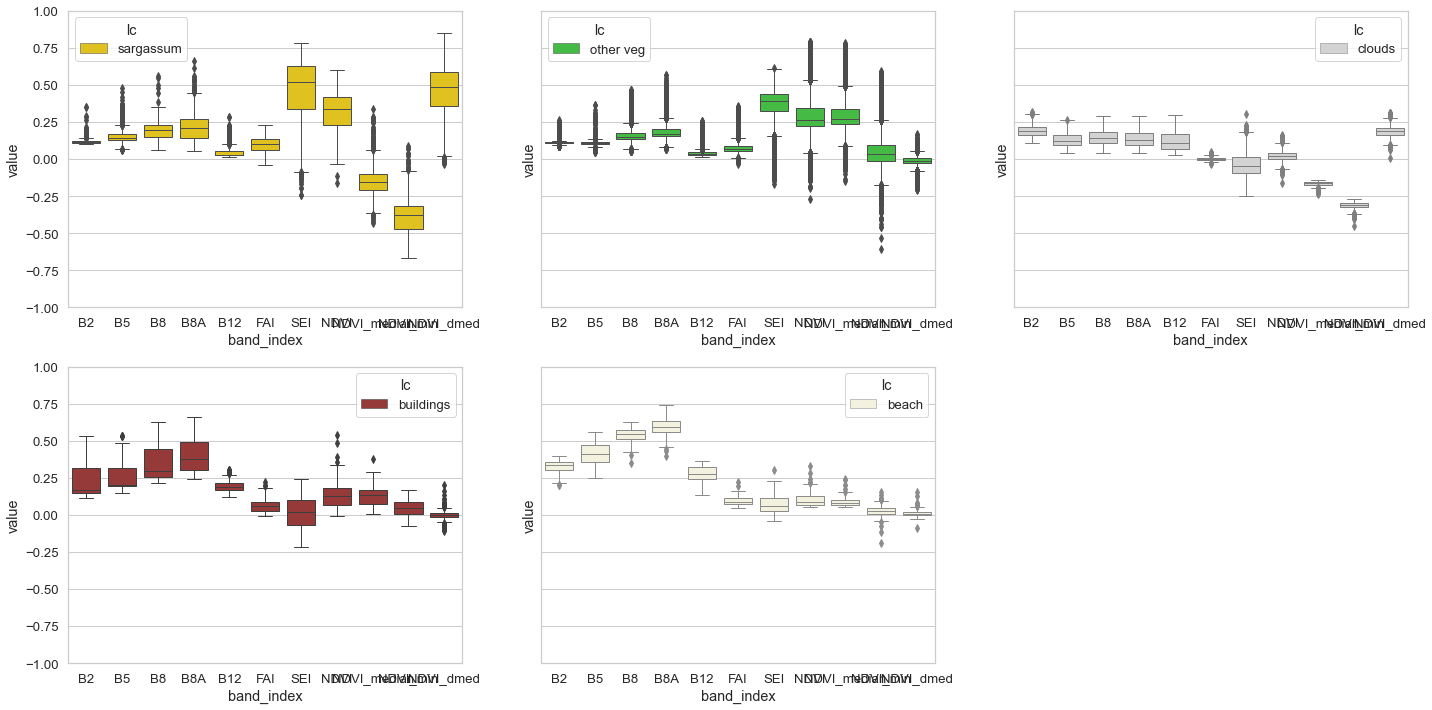

In [12]:
multi_boxplot(samples_toa_norm_gdf)

In [13]:
def dual_boxplot(sr_norm_gdf,toa_norm_gdf, lc_code):
    """ Creates a set of box plots for all land cover codes"""
    sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})
    f, axes = plt.subplots(1, 2,figsize=(24, 12), sharey=True)
    plt.ylim(-1, 1)
    sns.boxplot(ax=axes[0], x='band_index', y='value', hue='lc', data=sr_norm_gdf[sr_norm_gdf["lc_code"] == lc_code], palette=lc_palette)
    axes[0].set_title(label="SR")
    sns.boxplot(ax=axes[1], x='band_index', y='value', hue='lc', data=toa_norm_gdf[toa_norm_gdf["lc_code"] == lc_code], palette=lc_palette)
    axes[1].set_title(label="TOA")

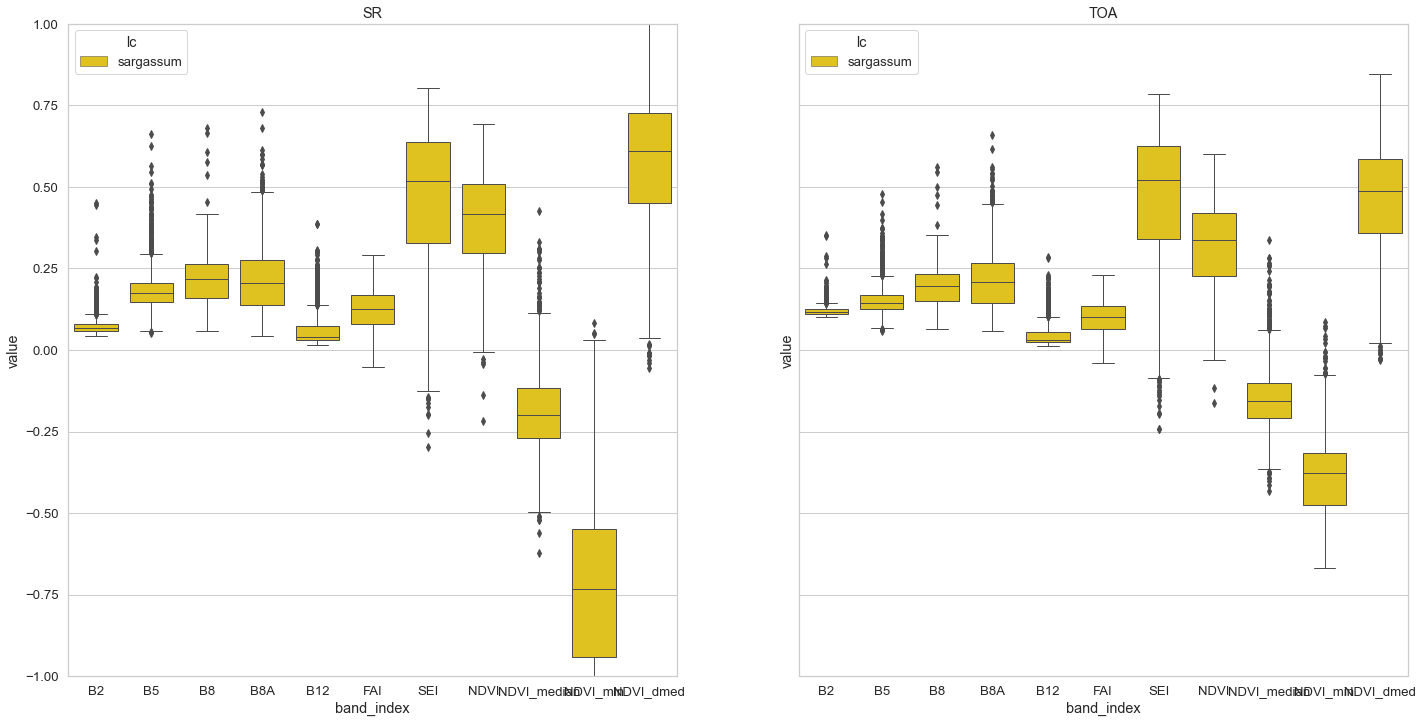

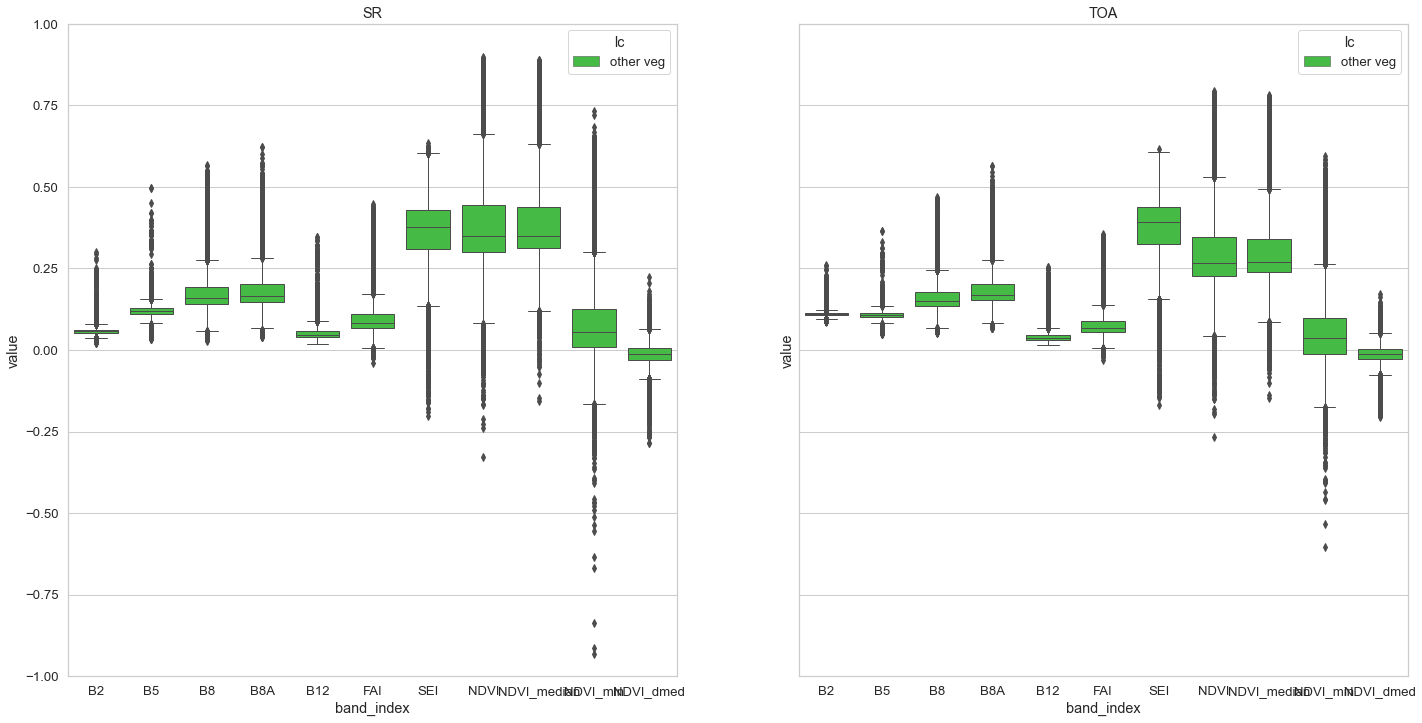

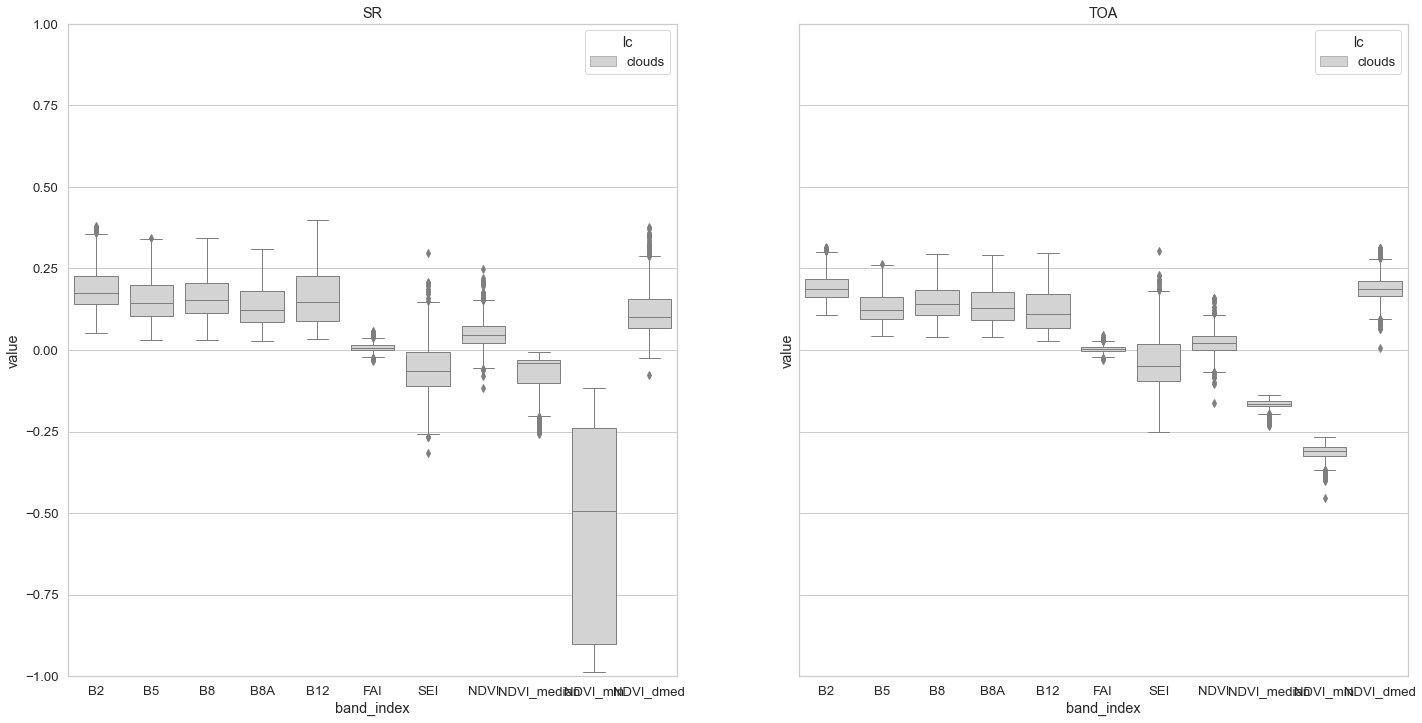

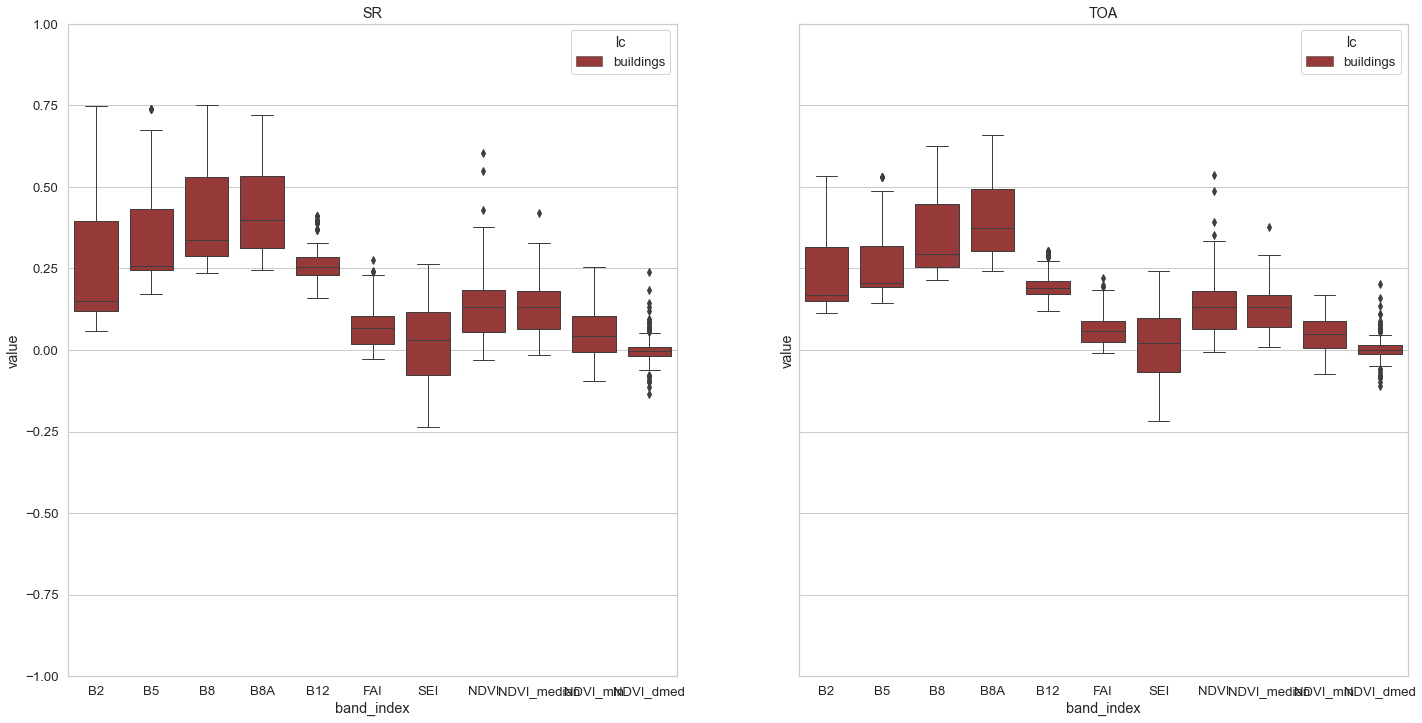

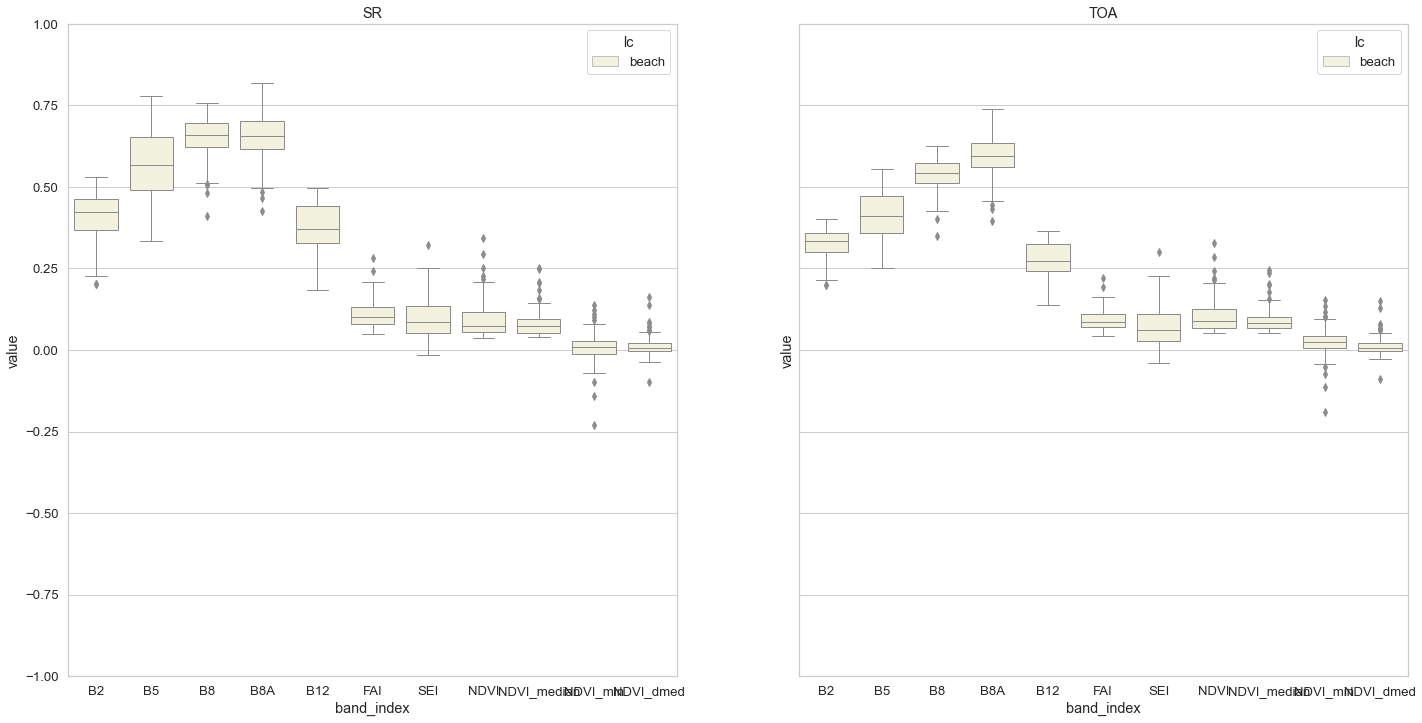

In [14]:
dual_boxplot(samples_sr_norm_gdf, samples_toa_norm_gdf, 0)
dual_boxplot(samples_sr_norm_gdf, samples_toa_norm_gdf, 1)
dual_boxplot(samples_sr_norm_gdf, samples_toa_norm_gdf, 4)
dual_boxplot(samples_sr_norm_gdf, samples_toa_norm_gdf, 3)
dual_boxplot(samples_sr_norm_gdf, samples_toa_norm_gdf, 2)
